In [1]:
import pyJvsip as pv
%matplotlib inline
from matplotlib.pyplot import *

In [2]:
def VU_vfrdB(a,rng):
    N_len=int(a.length)
    ca=a.otherEmpty.fill(0.0)
    fftType={'cvview_d':'ccfftip_d','cvview_f':'ccfftip_f'}[ca.type]
    fft =  pv.FFT(fftType,N_len,1,pv.VSIP_FFT_FWD,0,0)
    ra = ca.realview
    ia = ca.imagview
    ta = a.cloneview
    s  = ta.stride
    pv.copy(a,ra)
    fft.dft(ca)
    pv.cmagsq(ca,ra)
    maxv = ra.maxval
    minv = maxv * rng
    pv.clip(ra,minv,maxv,minv,maxv,ra)
    Nlen = int(N_len/2)
    if N_len%2:
         ta.putlength(Nlen+1)
         ra.putlength(Nlen+1)
         ta.putoffset(Nlen * s)
         pv.copy(ra,ta)
         ra.putlength(Nlen)
         ta.putlength(Nlen)
         ta.putoffset(a.offset)
         ra.putoffset(Nlen+1)
         pv.copy(ra,ta)
    else :
         pv.copy(ra,ta)
         ta.putlength(Nlen)
         a.putlength(Nlen)
         ta.putoffset(Nlen * s)
         pv.swap(ta,a)
         a.putlength(N_len)
    a.log10
    a *= 10.0

In [3]:
def VU_vwritexyg(fmt,x,y,fname):
    N=y.length
    of = open(fname,'w')
    of.write('%d\n'%N)
    for i in range(N):
        of.write(fmt%(x[i],y[i]))
    of.close()


In [4]:
def VU_vfreadxy(fname):
    fd = open(fname,'r')
    N=int(fd.readline())
    x=pv.create('vview_f',N)
    y=x.empty
    for i in range(N):
        ln=fd.readline().partition(' ')
        x[i]=float(ln[0])
        y[i]=float(ln[2])
    fd.close()
    return(x,y)

In [5]:
N_data = 24576
dec1 = 1
dec3 = 3
kernel=pv.create('vview_f',128).kaiser(15.0)
r_state  = pv.Rand('NPRNG',11)
data  = pv.create('vview_f', 2 * N_data)
noise = pv.create('vview_f', 3 * N_data)
avg   = pv.create('vview_f', 4 * N_data)
data.putlength(int((N_data-1)/dec1)+1)
avg.putlength(int((N_data-1)/dec1)+1)
data.putstride(2)
avg.putstride(4)
noise.putlength(N_data)
noise.putstride(3)
conv = pv.CONV('conv1d_f',kernel,pv.VSIP_NONSYM, N_data,dec1,pv.VSIP_SUPPORT_SAME,0,0)
fir  = pv.FIR('fir_f', kernel,'NONE', N_data,dec1,'NO')
avg.fill(0.0)
for i in range(10):
    r_state.randn(noise)
    conv.convolve(noise,data)
    VU_vfrdB(data,1e-13)
    pv.ma(data,0.1,avg,avg)
N_len = avg.length
x = pv.create('vview_f', N_len).ramp(-.5,1.0/float(N_len-1))
VU_vwritexyg("%8.6f %8.6f\n",x,avg,"conv_dec1");
avg.fill(0.0)
for i in range(10):
    r_state.randn(noise)
    fir.flt(noise,data)
    VU_vfrdB(data,1e-13)
    pv.ma(data,0.1,avg,avg)
N_len = avg.length
x = pv.create('vview_f', N_len).ramp(-.5,1.0/float(N_len-1))
VU_vwritexyg("%8.6f %8.6f\n",x,avg,"fir_dec1")
conv = pv.CONV('conv1d_f', kernel,pv.VSIP_NONSYM, N_data,dec3,pv.VSIP_SUPPORT_SAME,0,0);
fir  = pv.FIR('fir_f', kernel,'NONE', N_data,dec3,'NO')
data.putlength(int((N_data-1)/dec3) + 1)
avg.putlength(int((N_data-1)/dec3) + 1)
avg.fill(0.0)
for i in range(10):
    r_state.randn(noise)
    conv.convolve(noise,data);
    VU_vfrdB(data,1e-13);
    pv.ma(data,0.1,avg,avg)
N_len = avg.length
x = pv.create('vview_f', N_len).ramp(-.5,1.0/float(N_len-1))
VU_vwritexyg("%8.6f %8.6f\n", x, avg,"conv_dec3");
avg.fill(0.0)
for i in range(10):
    r_state.randn(noise)
    fir.flt(noise,data)
    VU_vfrdB(data,1e-13);
    pv.ma(data,0.1,avg,avg)
N_len = avg.length
x = pv.create('vview_f', N_len)
x.ramp(-.5,1.0/float(N_len-1))
VU_vwritexyg("%8.6f %8.6f\n", x, avg,"fir_dec3")
N_len = kernel.length
x = pv.create('vview_f', N_len)
x.ramp(0.0,1.0)
VU_vwritexyg("%8.6f %8.6f\n", x,kernel,"kaiser_window")
x.ramp(-.5,1.0/float(N_len-1))
VU_vfrdB(kernel,1e-20)
VU_vwritexyg("%8.6f %8.6f\n", x,kernel,"Freq_Resp_Kaiser")


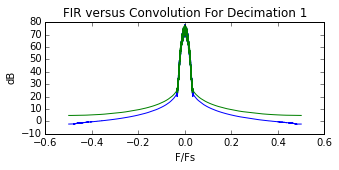

In [6]:
x,y=VU_vfreadxy('fir_dec1')
plot(x.list,y.list)
x,y=VU_vfreadxy('conv_dec1')
hold=True
plot(x.list,y.list)
ylabel('dB');xlabel('F/Fs');title('FIR versus Convolution For Decimation 1')
fig=gcf()
fig.set_size_inches(5,2)
fig.set_dpi(300)
hold=False
savefig('FirConvOne.eps',bbox_inches='tight')

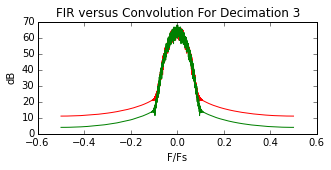

In [7]:
x,y=VU_vfreadxy('fir_dec3')
plot(x.list,y.list,'r');hold=True
x,y=VU_vfreadxy('conv_dec3')
plot(x.list,y.list,'g')
ylabel('dB');xlabel('F/Fs');title('FIR versus Convolution For Decimation 3')
fig=gcf()
fig.set_size_inches(5,2)
fig.set_dpi(300)
hold=False
savefig('FirConvTwo.eps',bbox_inches='tight')

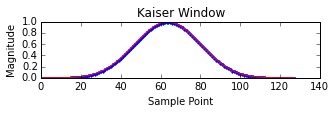

In [8]:
x,y=VU_vfreadxy('kaiser_window')
plot(x.list,y.list,'b.')
hold=True
plot(x.list,y.list,'r-')
fig=gcf()
fig.set_size_inches(5,1.)
fig.set_dpi(300)
ylabel('Magnitude');xlabel('Sample Point');title('Kaiser Window')
savefig('kaiserWindow.eps',bbox_inches='tight')

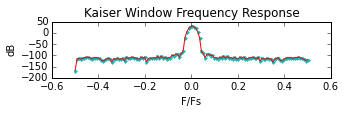

In [9]:
x,y=VU_vfreadxy('Freq_Resp_Kaiser')
plot(x.list,y.list,'c.')
hold=True
plot(x.list,y.list,'r-')
fig=gcf()
fig.set_size_inches(5,1.)
fig.set_dpi(300)
ylabel('dB');xlabel('F/Fs');title('Kaiser Window Frequency Response')
savefig('FreqRespKaiser.eps',bbox_inches='tight')